In [88]:
import pandas as pd
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score
import requests, json
from pprint import pprint

The player data per gameweek does not have the player's type eg: Midfielder, Defender etc associated with it . So the element_type column from the generic bootstrap API has been merged with the week wise player data to map the player's type

In [4]:
# base url for all FPL API endpoints
base_url = 'https://fantasy.premierleague.com/api/'

# get data from bootstrap-static endpoint
r = requests.get(base_url+'bootstrap-static/').json()

# show the top level fields
pprint(r, indent=2, depth=1, compact=True)

{ 'element_stats': [...],
  'element_types': [...],
  'elements': [...],
  'events': [...],
  'game_settings': {...},
  'phases': [...],
  'teams': [...],
  'total_players': 8614100}


In [5]:
players = r['elements']

In [6]:
players_df = pd.json_normalize(r['elements'])

In [14]:
df_type = pd.DataFrame(players_df['element_type'])
df_type.index.names = ['id']
df_type.head()

,element_type
id,
0,1
1,1
2,3
3,4
4,2


The merged data has been stored in csv files identified by the gaeweek numbers

In [23]:
for i in range(1,11):
    try:
        r = requests.get(f"https://fantasy.premierleague.com/api/event/{i}/live/").json()
        gw_player_df = pd.json_normalize(r['elements'])
        merged_player_df = pd.merge(gw_player_df, df_type, on=["id"])
        #merged_player_df.head()
        merged_player_df.to_csv(f"mergedweek_{i}.csv")
    except Exception as e:
        pass

To create the rankings table of the players the player data is grouped by the element type (Midfielder, Defender etc)
and sorted in descending order based on first the points and the points and ict index . The ict index in the data is a combination of the influence, creativity and threat features of the player.

Influence determines the player's ability to make an impact on a match either single or throughout the season by taking into account the events that affect the fixture(how well the FPL players perform) by analyzing goals, assists aswell as defensive actions to analyze the effectiveness of goalkeepers and defenders

Creativity analyzes the player's ability to produce goalscoring opportunities such as supplying assists.
Threat analyzes the player's ability to score goals.

As Ict Index combines all the 3 above values it becomes a significant feature in predicting the player's performance 


In [33]:
def common_elements(list1, list2):
    return list(set(list1) & set(list2))

In [43]:
def store_top_players(df_current_week,df_next_week,mul_points_dict,points_dict):
    df_sorted_cur_mul_features = df_current_week.sort_values(['stats.total_points', 'stats.ict_index'], ascending=[False, False])
    cur_week_player_ids_mul_features_50 = df_sorted_cur_mul_features['id'].tolist()[:50]
    
    df_sorted_cur_points = df_current_week.sort_values(['stats.total_points'], ascending=[False])
    cur_week_player_ids_points_50 = df_sorted_cur_points['id'].tolist()[:50]
    
    df_sorted_next_points = df_next_week.sort_values(['stats.total_points'], ascending=[False])
    next_week_player_ids_points_50 = df_sorted_next_points['id'].tolist()[:50]

    mul_points_dict[i]=len(common_elements(cur_week_player_ids_mul_features_50,next_week_player_ids_points_50))
    points_dict[i]=len(common_elements(cur_week_player_ids_points_50,next_week_player_ids_points_50))

In [108]:
#common_top_players_points={}
def getErrorRate(X_train,Y_train,X_test,Y_test,df_next_week,top_players_dict):
    new_pred_df = pd.DataFrame(df_next_week['id'])
    #print("inside error")
    model_points_pred = LinearRegression()
    model_points_pred.fit(X_train, Y_train)
    Y_pred_points = model_points_pred.predict(X_test)
    #print(points_output)
    new_pred_df['points_predicted'] = Y_pred_points
    
    df_sorted_next_points = new_pred_df.sort_values(['points_predicted'], ascending=[False])
    pred_player_ids_points_50 = df_sorted_next_points['id'].tolist()[:50]

    df_sorted_next_points = df_next_week.sort_values(['stats.total_points'], ascending=[False])
    next_week_player_ids_points_50 = df_sorted_next_points['id'].tolist()[:50]
    top_players_dict[i]=len(common_elements(pred_player_ids_points_50,next_week_player_ids_points_50))
    #return mean_squared_error(Y_test, Y_pred_points)

In [109]:
def regression_elem_typewise(df_cur_grp,df_next_grp,top_players_dict):
    X_train = df_cur_grp[['stats.bps','stats.ict_index','stats.clean_sheets','stats.goals_scored','stats.goals_conceded']]
    Y_train = df_cur_grp['stats.total_points']
    X_test = df_next_grp[['stats.bps','stats.ict_index','stats.clean_sheets','stats.goals_scored','stats.goals_conceded']]
    Y_test = df_next_grp['stats.total_points']
    getErrorRate(X_train,Y_train,X_test,Y_test,df_next_grp,top_players_dict)
    #print(error_rate)

In [111]:
common_top_players_cur_mul_points_1 = {}
common_top_players_cur_mul_points_2 = {}
common_top_players_cur_mul_points_3 = {}
common_top_players_cur_mul_points_4 = {}

common_top_players_points_1 = {}
common_top_players_points_2 = {}
common_top_players_points_3 = {}
common_top_players_points_4 = {}


top_players_pred_1 = {}
top_players_pred_2 = {}
top_players_pred_3 = {}
top_players_pred_4 = {}

df_current_week = pd.read_csv(f"mergedweek_{1}.csv")
grp_cur_type_players = df_current_week.groupby('element_type')
df_cur_grp_1 = grp_cur_type_players.get_group(1)
df_cur_grp_2 = grp_cur_type_players.get_group(2)
df_cur_grp_3 = grp_cur_type_players.get_group(3)
df_cur_grp_4 = grp_cur_type_players.get_group(4)
for i in range(2,11):
    try:
        #print("inside")
        df_next_week = pd.read_csv(f"mergedweek_{i}.csv")
        grp_next_type_players = df_next_week.groupby('element_type')
        df_next_grp_1 = grp_next_type_players.get_group(1)
        df_next_grp_2 = grp_next_type_players.get_group(2)
        df_next_grp_3 = grp_next_type_players.get_group(3)
        df_next_grp_4 = grp_next_type_players.get_group(4)
        
        store_top_players(df_cur_grp_1,df_next_grp_1,common_top_players_cur_mul_points_1,common_top_players_points_1)
        store_top_players(df_cur_grp_2,df_next_grp_2,common_top_players_cur_mul_points_2,common_top_players_points_2)
        store_top_players(df_cur_grp_3,df_next_grp_3,common_top_players_cur_mul_points_3,common_top_players_points_3)
        store_top_players(df_cur_grp_4,df_next_grp_4,common_top_players_cur_mul_points_4,common_top_players_points_4)
        
        
        regression_elem_typewise(df_cur_grp_1,df_next_grp_1,top_players_pred_1)
        regression_elem_typewise(df_cur_grp_2,df_next_grp_2,top_players_pred_2)
        regression_elem_typewise(df_cur_grp_3,df_next_grp_3,top_players_pred_3)
        regression_elem_typewise(df_cur_grp_4,df_next_grp_4,top_players_pred_4)
        
        df_cur_grp_1 = df_next_grp_1
        df_cur_grp_2 = df_next_grp_2
        df_cur_grp_3 = df_next_grp_3
        df_cur_grp_4 = df_next_grp_4
    except Exception as e:
        pass

In [112]:
print(top_players_pred_1)

{2: 45, 3: 48, 4: 44, 5: 49, 6: 48, 7: 50, 8: 48, 9: 47, 10: 46}


In [113]:
print(top_players_pred_2)

{2: 41, 3: 39, 4: 38, 5: 40, 6: 40, 7: 42, 8: 44, 9: 40, 10: 43}


The per element_type data frame is sorted in descending order based on first the points and the points and ict index.
The top 50 player ids were noted and they were compared with the sorted data based on points for the next gameweek.
The below plots show the number of common players in the top 50

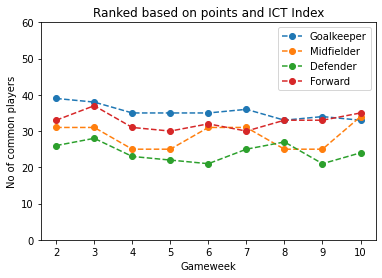

In [147]:
gameweek1 = list(common_top_players_cur_mul_points_1.keys())  
common_players1 = list((common_top_players_cur_mul_points_1.values()))
gameweek2 = list(common_top_players_cur_mul_points_2.keys())  
common_players2 = list((common_top_players_cur_mul_points_2.values()))
gameweek3 = list(common_top_players_cur_mul_points_3.keys())  
common_players3 = list((common_top_players_cur_mul_points_3.values()))
gameweek4 = list(common_top_players_cur_mul_points_4.keys())  
common_players4 = list((common_top_players_cur_mul_points_4.values()))
plt.xlabel('Gameweek')
plt.ylabel('No of common players')
plt.title('Ranked based on points and ICT Index')
plt.ylim([0, 60])
plt.plot(gameweek1, common_players1,marker="o",ls='--')
plt.plot(gameweek2, common_players2,marker="o",ls='--')
plt.plot(gameweek3, common_players3,marker="o",ls='--')
plt.plot(gameweek4, common_players4,marker="o",ls='--')
plt.legend(("Goalkeeper","Midfielder","Defender","Forward"))
plt.savefig("plot_points_ict.pdf")
plt.show()

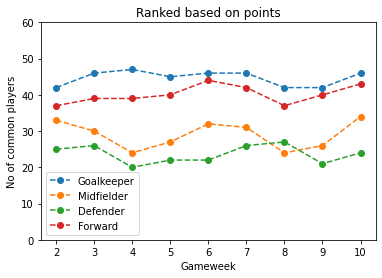

In [148]:
gameweek1 = list(common_top_players_points_1.keys())  
common_players1 = list((common_top_players_points_1.values()))
gameweek2 = list(common_top_players_points_2.keys())  
common_players2 = list((common_top_players_points_2.values()))
gameweek3 = list(common_top_players_points_3.keys())  
common_players3 = list((common_top_players_points_3.values()))
gameweek4 = list(common_top_players_points_4.keys())  
common_players4 = list((common_top_players_points_4.values()))
plt.xlabel('Gameweek')
plt.ylabel('No of common players')
plt.title('Ranked based on points')
plt.ylim([0, 60])
plt.plot(gameweek1, common_players1,marker="o",ls='--')
plt.plot(gameweek2, common_players2,marker="o",ls='--')
plt.plot(gameweek3, common_players3,marker="o",ls='--')
plt.plot(gameweek4, common_players4,marker="o",ls='--')
plt.legend(("Goalkeeper","Midfielder","Defender","Forward"))
plt.savefig("plot_points.pdf")
plt.show()

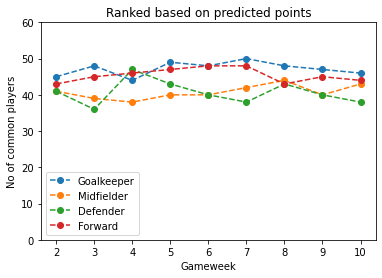

In [149]:
gameweek1 = list(top_players_pred_1.keys())  
common_players1 = list((top_players_pred_1.values()))
gameweek2 = list(top_players_pred_2.keys())  
common_players2 = list((top_players_pred_2.values()))
gameweek3 = list(top_players_pred_3.keys())  
common_players3 = list((top_players_pred_3.values()))
gameweek4 = list(top_players_pred_4.keys())  
common_players4 = list((top_players_pred_4.values()))
plt.xlabel('Gameweek')
plt.ylabel('No of common players')
plt.title('Ranked based on predicted points')
plt.ylim([0, 60])
plt.plot(gameweek1, common_players1,marker="o",ls='--')
plt.plot(gameweek2, common_players2,marker="o",ls='--')
plt.plot(gameweek3, common_players3,marker="o",ls='--')
plt.plot(gameweek4, common_players4,marker="o",ls='--')
plt.legend(("Goalkeeper","Midfielder","Defender","Forward"))
plt.savefig("plot_pred_points.pdf")
plt.show()

In [145]:
df_data = pd.read_csv(f"mergedweek_{1}.csv")
sorted_df = df_data.sort_values(['stats.total_points', 'stats.ict_index'], ascending=[False, False])
sorted_df.reset_index(drop=True, inplace=True)
sorted_df[['id','stats.bps','stats.influence','stats.creativity','stats.threat','stats.ict_index','stats.total_points']].head()

,id,stats.bps,stats.influence,stats.creativity,stats.threat,stats.ict_index,stats.total_points
0,277,61,106.2,35.9,59.0,20.1,20
1,233,49,70.6,36.4,70.0,17.7,17
2,272,46,74.8,60.0,15.0,15.0,16
3,122,46,56.0,35.5,29.0,12.1,15
4,527,37,45.4,7.0,11.0,6.3,14
